# Intel Stock Prices Historical Data (INTC)
In this notebook, we will predict the close price of stock named INTC.

Data Resource : https://www.kaggle.com/tosinabase/intel-stock-prices-historical-data-intc

By : Reynold Martua Sinambela

# Import Necessary Libary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import time

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Data
## From Kaggle

In [4]:
!pip install -q kaggle

In [6]:
# from google.colab import files
# files.upload()

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [8]:
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle kernels list — user YOUR_USER — sort-by dateRun

!kaggle competitions download -c DATASET

!unzip -q train.csv.zip -d .
!unzip -q test.csv.zip -d .
!ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dicoding - Machine Learning /INTC.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.199557,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.197961,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.202750,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.201952,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.194767,12172800


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = df['Close'].values

In [ ]:
data.shape

(10361,)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
data = data.reshape(1,-1)

In [ ]:
scaler.fit(data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
df['Close'] = scaler.transform(data).reshape(-1,)

# Data Preprocessing

## Checking Missing Value

In [ ]:
# check missing value
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Target Data

In [ ]:
# respon variable ('close' column)
y = df.iloc[:,4:5].astype(float).values

## Interval of Original Data

In [ ]:
y_max = max(y)[0]
y_min = min(y)[0]

In [ ]:
interval = y_max-y_min
interval

74.65885399281979

## Normalization

In [ ]:
# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler.fit_transform(y)

By this normalization, thus we can say that this data have interval in [0,1].

By this normalization, thus we can say that this data have interval in [0,1].

## Data Visualization

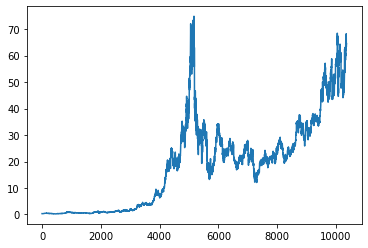

In [ ]:
# Plot of Original Data
plt.plot(y)
plt.show()

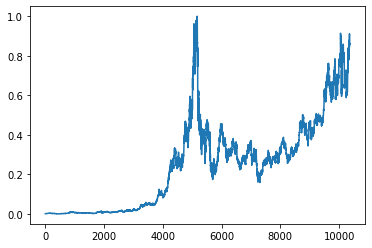

In [ ]:
# Plot of Scaled Data
plt.plot(scaled_y)
plt.show()

## ACF Plot to Determine The Number of Time Window

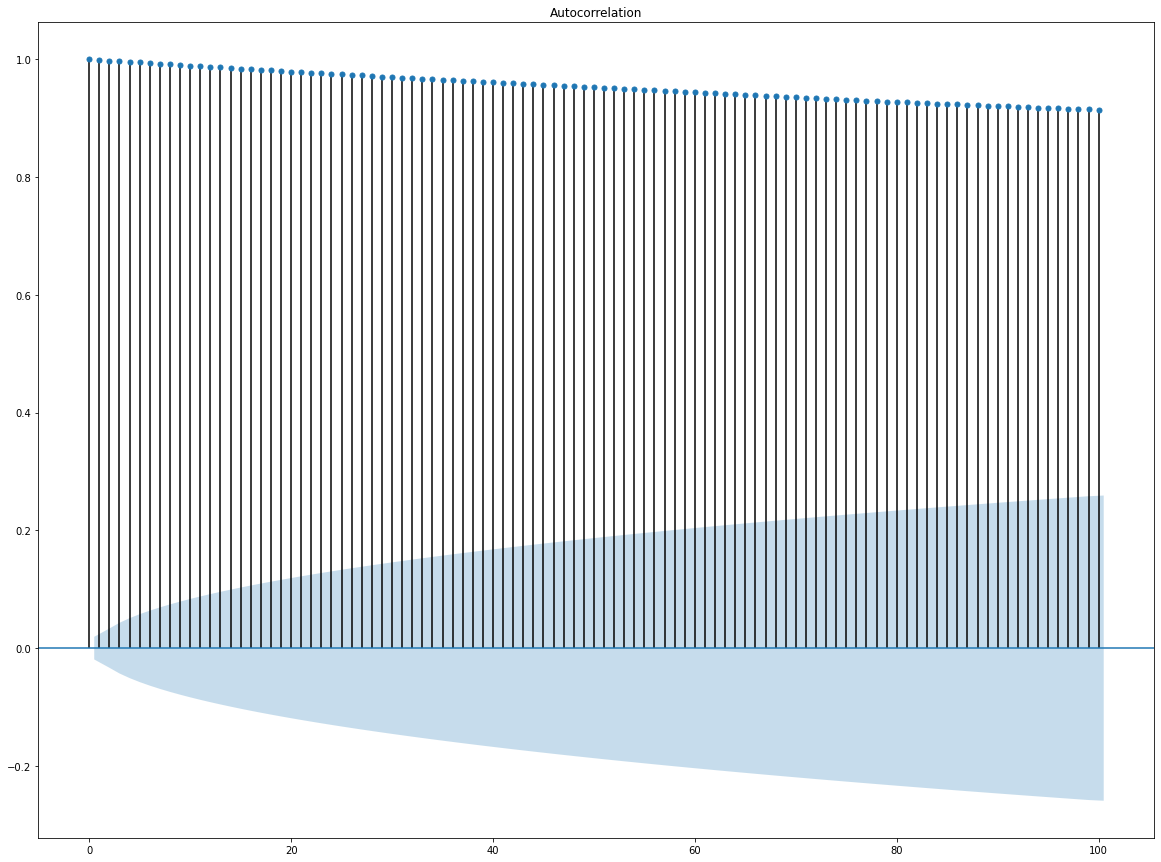

In [ ]:
# acf/pacf plot
fig,ax = plt.subplots(figsize=(20,15))
sm.graphics.tsa.plot_acf(scaled_y,lags=100,ax=ax);

It seems that there are many steps of time ($(t-k)^{th}$ time) that have acceptable correlation to current condition ($t^{th}$). However, because this is a daily data, we just choose one periode (e.g.) for time window.

## Create new Dataset based on Determined Time Window

In [ ]:
# create function of timewindow
def timewindow(y, window):
    obs  = len(y)-window
    yt   = y[:obs,:]
    for i in np.arange(1,window+1):
        yt = np.hstack((yt, y[i:obs+i,:]))
    return yt

In [ ]:
scaled_data = timewindow(scaled_y,1)

## Data Preview after Adding Time Window and Noise Variable (if necessary)

In [ ]:
scaled_data

array([[0.001465  , 0.00143012],
       [0.00143012, 0.00153475],
       [0.00153475, 0.00151731],
       ...,
       [0.85688238, 0.86799954],
       [0.86799954, 0.86438313],
       [0.86438313, 0.84938158]])

In [ ]:
# the shape of data
n_data,n_var = scaled_data.shape
n_data,n_var

(10360, 2)

Therefore, we have 10360 data with 3 variable (2 predictor, and other as target).

## Data Splitting
Split data to 20% data test, and the rest as data train.

In [ ]:
n_test = int(0.2*n_data)
n_test

2072

In [ ]:
X_scaled_train = scaled_data[:-n_test,:-1]
y_scaled_train = scaled_data[:-n_test,-1]

X_scaled_test = scaled_data[-n_test:,:-1]
y_scaled_test = scaled_data[-n_test:,-1]

## Reshape

In [ ]:
# reshape X_train and X_test to ndim = 3
X_scaled_train = np.reshape(X_scaled_train, (X_scaled_train.shape[0], 1, X_scaled_train.shape[1]))
X_scaled_test  = np.reshape(X_scaled_test,  (X_scaled_test.shape[0], 1, X_scaled_test.shape[1]))

# Modelling

## Model Architecture, Optimizer, and Loss

In [ ]:
from tensorflow.keras.initializers import Initializer

In [ ]:
model = tf.keras.models.Sequential([tf.keras.layers.LSTM(4, input_shape=(1,1), Initializer = tf.keras.initializers.GlorotUniform(seed=1)),
                                    tf.keras.layers.Dense(1, Initializer = tf.keras.initializers.GlorotUniform(seed=1))])

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-04)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])

model.summary()

TypeError: ignored

## Callback

In [ ]:
max_mae = 0.005 ; # 0.5% from scaled data

class StopCond(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<max_mae):
      print("MAE threshold condition has been satisfied.")
      self.model.stop_training = True


early_stopping    = StopCond()

## Training Model

In [ ]:
start_time = time.time()

In [ ]:
tf.random.set_seed(1234)
history = model.fit(X_scaled_train,y_scaled_train,epochs=100,batch_size=1, validation_data = (X_scaled_test,y_scaled_test) ,callbacks = [early_stopping])

Epoch 1/100
8288/8288 [==============================] - 17s 2ms/step - loss: 0.0056 - mae: 0.0746 - val_loss: 8.1322e-05 - val_mae: 0.0080
Epoch 2/100
8288/8288 [==============================] - 14s 2ms/step - loss: 3.3058e-05 - mae: 0.0045 - val_loss: 7.7263e-05 - val_mae: 0.0076
MAE threshold condition has been satisfied.


In [ ]:
# tf.random.set_seed(1234)
# history = model.fit(X_scaled_train,y_scaled_train,epochs=100,batch_size=1, validation_data = (X_scaled_test,y_scaled_test) ,callbacks = [early_stopping])

Epoch 1/100
8288/8288 [==============================] - 16s 2ms/step - loss: 0.0077 - mae: 0.0905 - val_loss: 4.2908e-04 - val_mae: 0.0228
Epoch 2/100
8288/8288 [==============================] - 15s 2ms/step - loss: 4.0641e-05 - mae: 0.0050 - val_loss: 8.4216e-05 - val_mae: 0.0083
MAE threshold condition has been satisfied.


In [ ]:
end_time = time.time()
durasi = (end_time - start_time)/60

print("Time elapsed to train model :",durasi,"minutes.")

From the training history above, the model has matched the maximum MAE condition which is 0.5% of scaled data.

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['Train Data', 'Test Data'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Data', 'Test Data'], loc='upper left')
plt.show()

# Model Evaluation on Test Data

## Model Evaluation on Validation/Test of Scaled Data

In [ ]:
y_scaled_test_predict = model.predict(X_scaled_test)

In [ ]:
mae = mean_absolute_error(y_scaled_test_predict,y_scaled_test)
print("MAE : " + str(mae) + " --> " + str(round(mae,3)*100) + "% of scaled data.")

## Plot of  Validation/Test of Scaled Data between Actual vs Predicted

In [ ]:
plt.plot(y_scaled_test, label = 'Actual Serries')
plt.plot(y_scaled_test_predict, label = 'Predicted Series')
plt.title('Plot of Scaled Data Test')
plt.legend()
plt.show()

From the plot above, it seems that the predicted data (by model) have good approximation to the scaled data test.

## Model Evaluation on Validation/Test of Original Data

In [ ]:
y_test = y[-n_test:]
y_test_predict = scaler.inverse_transform(y_scaled_test_predict)

In [ ]:
mae = mean_absolute_error(y_test_predict,y_test)
print("MAE : " + str(mae) + " --> " + str(round(mae,3)*100/interval) + "% of original data.")

## Plot of  Validation/Test of Original Data between Actual vs Predicted

In [ ]:
plt.plot(y_test, label = 'Actual Serries')
plt.plot(y_test_predict, label = 'Predicted Series')
plt.title('Plot of Original Data Test')
plt.legend()
plt.show()

From the plot above, it seems that the predicted data (by model) have good approximation to the original data test.